In [77]:
import pyarrow as pa
import dask.dataframe as dd
import pandas as pd

from pandas.io.json import json_normalize
import datetime

In [20]:
def lateral_flatten(df):
    rows = []
    for i, row in df.iterrows():
        particpiant_identities = row.at['participantIdentities']
        lateral_pi = json_normalize(particpiant_identities)
        participants = row.at['participants']
        lateral_p = json_normalize(participants, meta_prefix='participant')
        teams = row.at['teams']
        lateral_teams = json_normalize(teams, meta_prefix ='team')
        
        merge1 = pd.merge(lateral_pi, lateral_p, on='participantId')
        merge2 = pd.merge(merge1, lateral_teams, on='teamId')
        
        for j, participant_row in merge2.iterrows():
            new = row.copy()
            
            new_row = pd.concat([new, participant_row])
            rows.append(new_row)

    df2 = pd.DataFrame(rows)
    return df2.drop(['participantIdentities', 'participants', 'teams'], axis=1)

In [86]:
def extractShortVersion(x):
    split_array = x.split('.')
    major = split_array[0]
    minor = split_array[1]
    if len(minor) < 2:
        minor = "0{num}".format(num=minor)
    return float("{major}.{minor}".format(major=major, minor=minor))

In [12]:
ddf = dd.read_json('s3://riot-raw-games-ingestion-raw-games-us-east-1-166391258436/games-raw/2018/10/*/*/*',
                   lines=True,
                   convert_axes=True)

In [23]:
df_raw = ddf.compute()

In [18]:
df_raw.gameCreation = pd.to_datetime(df_raw['gameCreation'], origin='unix', unit='ms')

In [87]:
df_raw['date'] = df_raw.gameCreation.apply(lambda x: x.date())
df_raw['shortVersion'] = df_raw.gameVersion.apply(extractShortVersion)

In [81]:
df_raw = df_raw[df_raw['date'] >= datetime.date(year=2018, month=10, day=1)]

In [89]:
df_raw.shortVersion.unique()

array([8.2 , 8.19, 8.21])

In [91]:
df = lateral_flatten(
    df_raw[(df_raw['queueId'] == 400) | (df_raw['queueId'] == 420) | (df_raw['queueId'] == 440)]
).reset_index(drop=True).drop(['bans'], axis=1)

In [92]:
print(df.gameCreation.min())
df.gameCreation.max()

2018-10-01 00:59:15.387000


Timestamp('2018-10-25 03:21:53.602000')

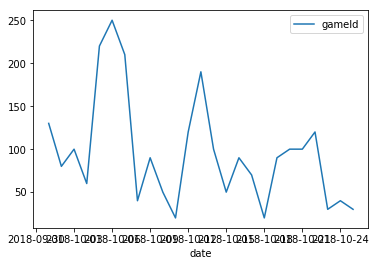

In [95]:
df.groupby(['date'])[['gameId']].count().plot()

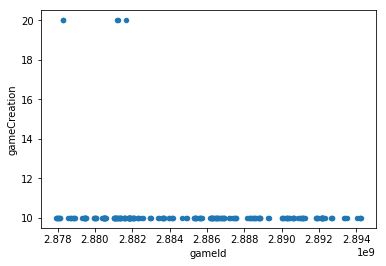

In [96]:
df.groupby('gameId', as_index=False).count()[['gameId', 'gameCreation']].plot(kind='scatter', x='gameId', y='gameCreation')

In [97]:
df['countnumber'] = df.sort_values([
    'gameId', 
    'player.accountId'
]).groupby([
    'gameId',
    'player.accountId'
]).cumcount() + 1

In [98]:
df2 = df.drop(df[df.countnumber > 1].index)

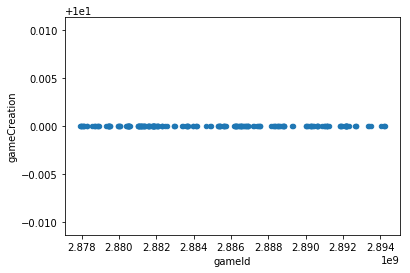

In [101]:
df2.groupby('gameId', as_index=False).count()[['gameId', 'gameCreation']].plot(kind='scatter', x='gameId', y='gameCreation')

In [102]:
df2.to_parquet('../recent-export.parquet', engine='pyarrow')